<a href="https://colab.research.google.com/github/shininini/comparison/blob/master/Copy_of_DSDG_TP1_G1_CLEAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Instalación de dependencias e importación de módulos**

---



In [ ]:
!pip install geopandas==0.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 83.5 MB/s eta 0:00:00


In [ ]:
import re
import gdown
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Point
from geopy.distance import geodesic
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerPatch
import seaborn as sns
import pyproj
from google.colab import files




---


## **Presentación de datos del dataset original**
   1. Cantidad de NaN por columna (gráfico)
   2. Análisis por columna
   3. Estrategia de limpieza de datos






### **1 - a)** Lectura de CSV

In [ ]:
csv_url = "https://drive.google.com/uc?id=1UxFW8Pbg2Lnxr1KJJp3qNxa1RdVgrC-l"

output = "/content/properatti.csv"
gdown.download(csv_url, output, quiet=False)

  , index_col='Unnamed: 0')
# data.sample(3)

Downloading...
From: https://drive.google.com/uc?id=1UxFW8Pbg2Lnxr1KJJp3qNxa1RdVgrC-l
To: /content/properatti.csv
100%|██████████| 149M/149M [00:02<00:00, 51.4MB/s]


### **1 - b)** Renombramos la columnas

In [ ]:
# print(data.columns)
data.rename(columns= {'state_name': 'province_name', 'lat' : 'latitude', 'lon' : 'longitude',
                      'price_aprox_local_currency' : 'price_aprox_ARS', 'price_per_m2' : 'price_ARS_per_m2'}, inplace=True)

### **1 - c)** Graficamos nulos y observaciones

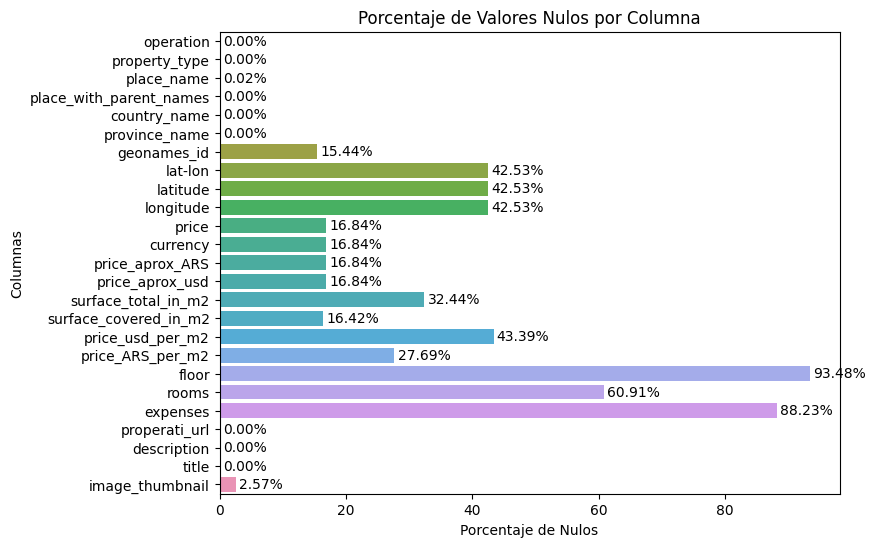

In [ ]:
# obtenemos el porcentaje de valores nulos en cada columna.
# hacemos una función para gráficar ya que probablemente la usemos más adelante.
def graficar_nulos(data):
    null_percentages = data.isnull().sum() / len(data) * 100
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x=null_percentages.values, y=null_percentages.index, ax=ax)
    ax.set_xlabel('Porcentaje de Nulos')
    ax.set_ylabel('Columnas')
    ax.set_title('Porcentaje de Valores Nulos por Columna')
    for i, v in enumerate(null_percentages.values):
      ax.text(v + 0.5, i, f'{v:.2f}%', color='black', va='center')
    plt.show()

graficar_nulos(data)

### **2 - a)** Análisis por columnas


> Para todas las columnas se analizaron valores nulos, tipo y que cantidad de cada valor



In [ ]:
# analizamos valores unicos y tipos de cada una columna (mostramos solo los 5 primeros)
def obtener_valores_y_tipos(dataframe):
    for columna in dataframe.columns:
        valores_unicos = dataframe[columna].value_counts()
        tipo_dato = dataframe[columna].dtype
        nulos = dataframe[columna].isnull().sum() / len(data) * 100
        print(f"Columna: {columna}")
        print(f"Tipo de dato: {tipo_dato}")
        print(f"Porcentaje de nulos: {nulos}")
        print("Valores:")
        print(valores_unicos)
        print("-" * 50)

# descomentar para ver los valores
obtener_valores_y_tipos(data)

Columna: operation
Tipo de dato: object
Porcentaje de nulos: 0.0
Valores:
sell    121220
Name: operation, dtype: int64
--------------------------------------------------
Columna: property_type
Tipo de dato: object
Porcentaje de nulos: 0.0
Valores:
apartment    71065
house        40268
PH            5751
store         4136
Name: property_type, dtype: int64
--------------------------------------------------
Columna: place_name
Tipo de dato: object
Porcentaje de nulos: 0.018973766705164163
Valores:
Córdoba               9254
Rosario               8504
Mar del Plata         6534
Tigre                 3324
Nordelta              3315
                      ... 
Sierras Bayas            1
Paso de los Libres       1
Azara                    1
Coronel Du Graty         1
Altos de Hudson I        1
Name: place_name, Length: 1060, dtype: int64
--------------------------------------------------
Columna: place_with_parent_names
Tipo de dato: object
Porcentaje de nulos: 0.0
Valores:
|Argentina|Santa F

Llegamos a la conclusión que las siguientes columnas no aportan valor a nuestro análisis inicial:

- **floor**: no aportan valor por la **cantidad de nulos**
- **rooms**: no aportan valor por la **cantidad de nulos**
- **expenses**: no aportan valor por la **cantidad de nulos**
- **country_name**: no aporta valor porque todos sus datos son **argentina**
- **operation**: no aporta valor porque todos sus datos son **sell**
- **image_thumbnail**: no aporta valor, todos los links a imagenes



### **3 - a)** Estrategia de limpieza de los datos.

  - Después de la conclusión anterior podemos eliminar las columnas que no consideramos necesarias

In [ ]:
data.drop(['operation', 'country_name', 'floor', 'rooms', 'expenses', 'image_thumbnail'], axis=1, inplace=True)
# data.sample(3)

---
# **Presentación de datos del dataset con modificaciones**
### 4. Limpieza y extracción por columnas

### **4 -a)** Columnas place_name, place_with_parent_names


> Notamos que la columna 'place_name' arroja el grado máximo de precisión que conoce de una propiedad. A veces esto es el barrio pero a veces es la provincia.





In [ ]:
data['place_name'].value_counts()

Córdoba               9254
Rosario               8504
Mar del Plata         6534
Tigre                 3324
Nordelta              3315
                      ... 
Sierras Bayas            1
Paso de los Libres       1
Azara                    1
Coronel Du Graty         1
Altos de Hudson I        1
Name: place_name, Length: 1060, dtype: int64



> A veces una misma etiqueta (como en este caso Córdoba) indica unidades geográficas diferentes! (provincia vs. ciudad, por ejemplo):



In [ ]:
data.loc[data['place_name']=='Córdoba', ['place_name', 'place_with_parent_names']]


,place_name,place_with_parent_names
10,Córdoba,|Argentina|Córdoba|Córdoba|
32,Córdoba,|Argentina|Córdoba|Córdoba|
87,Córdoba,|Argentina|Córdoba|Córdoba|
88,Córdoba,|Argentina|Córdoba|Córdoba|
89,Córdoba,|Argentina|Córdoba|Córdoba|
...,...,...
121202,Córdoba,|Argentina|Córdoba|
121203,Córdoba,|Argentina|Córdoba|
121204,Córdoba,|Argentina|Córdoba|
121205,Córdoba,|Argentina|Córdoba|




> Como el grado de precisión que tiene de cada propiedad es muy variable, decidimos subdividirla en columnas.

> Para hacerlo trabajaremos con la columna 'place_with_parent_names' y haremos un split por el simbolo '|'



In [ ]:
# Separamos cada grado de precision en diferentes columnas usando el metodo split
data_distritos = data['place_with_parent_names'].str.split('|', expand=True)
data_distritos.columns = ['axis', 'country', 'province', 'city', 'neighborhood', 'neighborhood_2', 'neighborhood_3']
data_distritos

,axis,country,province,city,neighborhood,neighborhood_2,neighborhood_3
0,,Argentina,Capital Federal,Mataderos,,None,None
1,,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,,None,None
2,,Argentina,Capital Federal,Mataderos,,None,None
3,,Argentina,Capital Federal,Liniers,,None,None
4,,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,Centro,,None
...,...,...,...,...,...,...,...
121215,,Argentina,Capital Federal,Belgrano,,None,None
121216,,Argentina,Bs.As. G.B.A. Zona Norte,San Isidro,Beccar,,None
121217,,Argentina,Capital Federal,Villa Urquiza,,None,None
121218,,Argentina,Buenos Aires Costa Atlántica,Mar del Plata,Plaza Colón,,None


Analizamos las columnas obtenidas:

- **country**: no aporta valor porque es el **mismo valor para todas las filas**
- **province**: no aporta valor porque ya **existe una columna con esta información**
- **city**: tiene datos de las ciudades limpios, con la cual podemos limpiar place_name
- **neighborhood**: tiene datos de las localidades limpias
- **neighborhood_2**: no aportan valor por la **cantidad de nulos**
- **neighborhood_3**: no aportan valor por la **cantidad de nulos**

Por lo cual nos quedaremos con las columnas city y neighborhood


In [ ]:
data['place_name'] = data_distritos['city']
data['neighborhood'] = data_distritos['neighborhood']
data.head(3)

,property_type,place_name,place_with_parent_names,province_name,geonames_id,lat-lon,latitude,longitude,price,currency,price_aprox_ARS,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_ARS_per_m2,properati_url,description,title,neighborhood
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.000000,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,
1,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,USD,2646675.0,150000.0,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,
2,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,55.0,55.0,1309.090909,1309.090909,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,


> Re ordenamos las columnas y eliminamos las columnas que tienen información redundate



In [ ]:
column_order = [
    'property_type',
    'province_name',
    'place_name',
    'neighborhood',
    'geonames_id',
    'lat-lon',
    'latitude',
    'longitude',
    'price',
    'currency',
    'price_aprox_ARS',
    'price_aprox_usd',
    'surface_total_in_m2',
    'surface_covered_in_m2',
    'price_usd_per_m2',
    'price_ARS_per_m2',
    'properati_url',
    'description',
    'title',
    ]

data = data[column_order]
data.head(3)


,property_type,province_name,place_name,neighborhood,geonames_id,lat-lon,latitude,longitude,price,currency,price_aprox_ARS,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_ARS_per_m2,properati_url,description,title
0,PH,Capital Federal,Mataderos,,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.000000,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB
1,apartment,Bs.As. G.B.A. Zona Sur,La Plata,,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,150000.0,USD,2646675.0,150000.0,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...
2,apartment,Capital Federal,Mataderos,,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,55.0,55.0,1309.090909,1309.090909,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO


## **4 -b)** Columnas price, currency, price_aprox_ARS, price_aprox_USD

> Analizamos los diferentes tipo de moneda que aparecen en el dataset y buscamos datos que sea necesario analizar, reemplazar y/o quitar.


In [ ]:
data.currency.unique()

array(['USD', nan, 'ARS', 'PEN', 'UYU'], dtype=object)

> Analizamos que registros aparecen para el tipo de currency igual a 'USD'.

In [ ]:
# Creamos una mask para sacar las filas con nulls en las columnas relacionadas al precio.
mask_precio_is_not_null = data.price.notnull() & data.currency.notnull() & data.price_aprox_ARS.notnull() & data.price_aprox_usd.notnull()
# Aplicamos la mask y guardamos unicamente las columnas relacionadas al precio.
data_not_null=data.loc[mask_precio_is_not_null,['price','currency','price_aprox_ARS','price_aprox_usd']]
# Printeo la data con currency = 'USD'
data_currency=data_not_null[data_not_null.currency=='USD']
data_currency

,price,currency,price_aprox_ARS,price_aprox_usd
0,62000.0,USD,1093959.00,62000.0
1,150000.0,USD,2646675.00,150000.0
2,72000.0,USD,1270404.00,72000.0
3,95000.0,USD,1676227.50,95000.0
4,64000.0,USD,1129248.00,64000.0
...,...,...,...,...
121215,870000.0,USD,15350715.00,870000.0
121216,498000.0,USD,8786961.00,498000.0
121217,131500.0,USD,2320251.75,131500.0
121218,95900.0,USD,1692107.55,95900.0


> Analizamos que registros aparecen para el tipo de currency igual a **UYU**

> Observamos que existe un solo registro para este tipo de currency cuyo campo
price_aprox_usd corresponde a un outlier.

In [ ]:
# Creamos una mask para sacar las filas con nulls en las columnas relacionadas al precio.
mask_precio_is_not_null = data.price.notnull() & data.currency.notnull() & data.price_aprox_ARS.notnull() & data.price_aprox_usd.notnull()
# Aplicamos la mask y guardamos unicamente las columnas relacionadas al precio.
data_not_null=data.loc[mask_precio_is_not_null,['price','currency','price_aprox_ARS','price_aprox_usd']]
# Printeo la data con currency = 'UYU'
data_curr=data_not_null[data_not_null.currency=='UYU']
data_curr

,price,currency,price_aprox_ARS,price_aprox_usd
107390,650000000.0,UYU,4.054773e+08,22980378.29


> Analizamos que registros aparecen para el tipo de currency igual a 'PEN'


In [ ]:
# Creamos una mask para sacar las filas con nulls en las columnas relacionadas al precio.
mask_precio_is_not_null = data.price.notnull() & data.currency.notnull() & data.price_aprox_ARS.notnull() & data.price_aprox_usd.notnull()
# Aplicamos la mask y guardamos unicamente las columnas relacionadas al precio.
data_not_null=data.loc[mask_precio_is_not_null,['price','currency','price_aprox_ARS','price_aprox_usd']]
# Printeo la data con currency = 'PEN'
data_curr=data_not_null[data_not_null.currency=='PEN']
data_curr

,price,currency,price_aprox_ARS,price_aprox_usd
50387,380000.0,PEN,2066864.90,117139.33
50388,950000.0,PEN,5167162.35,292848.33


Habiendo analizado los 4 tipos de currency con datos no nulos, procedemos a:
- **Borrar** el registro correspondiente al **tipo de cambio 'UYU'**
- **Borrar** los registros cuyo campo **'price_aprox_usd' sea superior al valor correspondiente al percentil 99 en USD**. Asumimos que estos registros son **errores del dataset**.

In [ ]:
print(data.shape)
# Borra el registro correspondiente al tipo de cambio 'UYU'
data = data.drop([107390])
# Borra los registros cuyo precio es mayor al 99% en USD (1.6M)
data = data.drop(data[data.price_aprox_usd > 1600000].index)
data.shape

(121220, 19)


(120363, 19)


Lógicas de reemplazo para datos relacionados al precio:
- Mediante expresiones regulares se buscará obtener el valor en USD del campo 'description' para ver si se pueden reemplazar los NaN por lo que se logre resactar de la misma.

- Para aquellos registros NaN donde no se pueda obtener el valor de la propiedad del campo 'description' se aplicará otra lógica de reemplazo.

> El punto 1 queda descartado dado que para ciertos registros la columna 'description' existen varios valores en USD, por lo que se hace díficil determinar cual es el que corresponde.
Esto podría llevar a que el valor obtenido de dicha columna sea incorrecto.
A continuación, se muestra un ejemplo:

In [ ]:
descriptions=data['description'].astype(str)
# Busca un patron que empiece con 'USD', tiene en cuenta que puede o no haber un espacio separando el valor numerico y las letras USD.
# Ademas tiene en cuenta que puede tener un punto decimal, y en el caso de que haya, lee los numeros decimales despues del punto.
pattern=r'USD\s?(\d+(\. \d+)?)'
pattern_regex = re.compile(pattern)
resultado = descriptions.apply(lambda x: pattern_regex.findall(x))
print(resultado[25])

print(data.loc[25,'description'])

[('71', ''), ('106', ''), ('385', '')]
EXCLUSIVO  DEPARTAMENTO DE EXCELENTE CATEGORÍA EN VENTA EN CASTELAR160 MTS2  Cubiertos.  4 ambientes con balcón terraza, parrilla y cochera. Entrega marzo 2018.EL PRECIO PUBLICADO CORRESPONDE AL VALOR DE CONTADO para las unidades de tercer y cuarto piso. FINANCIACIÓN: ANTICIPO USD 71.800, USD106.000 A LA ESCRITURA Y  EL RESTO FINANCIADO EN 36 CUOTAS (con refuerzos semestrales) VALOR FINANCIADO USD 385.640Piso con Palier privado con puerta de seguridad  y entrada de servicio. Linving comedor , 3 dormitorios uno de los cuales es en suite  con ducha escocesa, con vestidor. Otros 2 dormitorios con placars  que comparten un baño completo con bañera.  pisos de madera en dormitorios y living comedor, pisos de porcelanato en pasillos y cocina. ventanas de aluminio con DVH (doble vidrio hermético) en todo el depto. Cocina completa (con cocina vitroceramica, horno eléctrico, microondas, heladera con frezzer, cafetera express todos marca BGH),  despensa y la

> En un mismo registro tenemos 3 valores en USD: el anticipo, el total a entregar en el momento de la escritura y el total financiado.


> Para el punto 2 podemos buscar los registros que tienen Nan en el campo 'price_aprox_usd' y chequear si esos registros tienen el dato de 'surface_total_in_m2'.
Si tienen dicho dato, entonces podemos estimar el precio multiplicando la superficie por el valor promedio en usd del m2.
Si no tienen dicho dato, entonces primero hay que estimar el campo 'surface_total_in_m2' y luego realizar la multiplicación.

> Procedemos a chequear, cuales de los registros que tienen Nan en el campo 'price_aprox_usd' (en total son 20410 registros) también tienen datos NaN en el campo 'surface_total_in_m2'.


In [ ]:
mask_precio_is_null = data.price.isnull() & data.currency.isnull() & data.price_aprox_ARS.isnull() & data.price_aprox_usd.isnull() & data.surface_total_in_m2.isnull() & data.price_ARS_per_m2.isnull()
registros_sin_precio_sin_sup = data.loc[mask_precio_is_null,['price','currency','price_aprox_ARS','price_aprox_usd','surface_total_in_m2']]
print("Cant. registros sin dato de precio y de sup.:",registros_sin_precio_sin_sup.shape[0], "--> CASO 1")

mask_precio_is_null_y_sup = data.price.isnull() & data.currency.isnull() & data.price_aprox_ARS.isnull() & data.price_aprox_usd.isnull() & data.surface_total_in_m2.notnull()
registros_sin_precio_con_sup = data_null_y_sup=data.loc[mask_precio_is_null_y_sup,['price','currency','price_aprox_ARS','price_aprox_usd','surface_total_in_m2']]
print("Cant. registros sin dato de precio y con dato de sup.:",registros_sin_precio_con_sup.shape[0], "--> CASO 2")

mask_precio_is_null_y_sup_v2 = data.price.isnull() & data.currency.isnull() & data.price_aprox_ARS.isnull() & data.price_aprox_usd.isnull() & data.surface_total_in_m2.notnull() & data.price_ARS_per_m2.notnull()
registros_sin_precio_con_sup_v2 = data_null_y_sup=data.loc[mask_precio_is_null_y_sup_v2,['price','currency','price_aprox_ARS','price_aprox_usd','surface_total_in_m2']]
print("Cant. registros sin dato de precio y con dato de sup y dato de valor por m2.:",registros_sin_precio_con_sup_v2.shape[0], "--> CASO 3")

mask_precio_is_null_v2 = data.price.isnull() & data.currency.isnull() & data.price_aprox_ARS.isnull() & data.price_aprox_usd.isnull() & data.surface_total_in_m2.isnull() & data.price_ARS_per_m2.isnull() & data.surface_covered_in_m2.isnull()
registros_sin_precio_sin_sup = data.loc[mask_precio_is_null_v2,['price','currency','price_aprox_ARS','price_aprox_usd','surface_total_in_m2']]
print("Cant. :",registros_sin_precio_sin_sup.shape[0], "--> CASO 4")

mask_precio_is_null_y_sup = data.price.isnull() & data.currency.isnull() & data.price_aprox_ARS.isnull() & data.price_aprox_usd.isnull() & data.surface_total_in_m2.notnull()
registros_sin_precio_con_sup = data_null_y_sup=data.loc[mask_precio_is_null_y_sup,['price','currency','price_aprox_ARS','price_aprox_usd','surface_total_in_m2']]
print(registros_sin_precio_con_sup)

Cant. registros sin dato de precio y de sup.: 7384 --> CASO 1
Cant. registros sin dato de precio y con dato de sup.: 13026 --> CASO 2
Cant. registros sin dato de precio y con dato de sup y dato de valor por m2.: 0 --> CASO 3
Cant. : 4733 --> CASO 4
        price currency  price_aprox_ARS  price_aprox_usd  surface_total_in_m2
5         NaN      NaN              NaN              NaN                 53.0
20        NaN      NaN              NaN              NaN                148.0
41        NaN      NaN              NaN              NaN                115.0
62        NaN      NaN              NaN              NaN                156.0
67        NaN      NaN              NaN              NaN                220.0
...       ...      ...              ...              ...                  ...
121129    NaN      NaN              NaN              NaN                 59.0
121211    NaN      NaN              NaN              NaN                205.0
121212    NaN      NaN              NaN          

> Para el **caso 1**: primero estimar valores de superficie total en m2, después estimar valor promedio en usd del m2 según la zona y tipo de propiedad en USD, y por último
multiplicar el primero por el segundo. Para este caso hay que estimar ambos parámetros (sup y valor por m2).

> Para el **caso 2**: como ya tenemos el dato de la superficie, solo hay que estimar el valor por m2 promedio en local currency, y luego debemos multiplicar el primero por el segundo.
En el caso de que currency sea 'ARS' ,entonces, además hay que dividir por el tipo de cambio promedio para tener el valor en USD.

> Hacemos una máscara con los 7384 registros y analizamos los datos. Se puede observar el alto % de NaN para todas las columnas referidas a precio y superficie.
¿Descartamos estos datos?

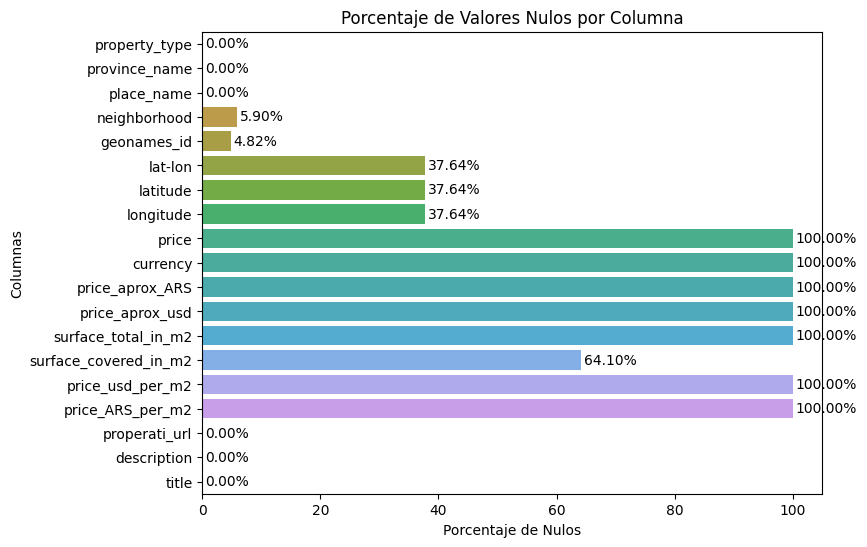

In [ ]:
mask_precio_is_null = data.price.isnull() & data.currency.isnull() & data.price_aprox_ARS.isnull() & data.price_aprox_usd.isnull() & data.surface_total_in_m2.isnull() & data.price_ARS_per_m2.isnull()
registros_sin_precio_sin_sup = data.loc[mask_precio_is_null,:]

graficar_nulos(registros_sin_precio_sin_sup)

> Hacer reemplazos y analizar media, desvio, etc para la base como está y aplicando lógica de reemplazo.


In [ ]:
data['concat_id']=data.province_name+data.place_name+data.property_type
data_v2=data.join(data.groupby('concat_id')['price_ARS_per_m2'].mean(), on='concat_id', rsuffix='_promedio')

data_v2.drop(data_v2[data_v2.price.isnull() & data_v2.currency.isnull() & data_v2.price_aprox_ARS.isnull() & data_v2.price_aprox_usd.isnull() & data_v2.surface_total_in_m2.isnull() & data_v2.price_ARS_per_m2.isnull()].index, inplace=True)

data_v2["price_completo"]= np.where(data_v2.price.notnull(),
                                    data_v2.price,
                                    data_v2.surface_total_in_m2* data_v2.price_ARS_per_m2_promedio)
data_v2["currency_completo"]= np.where(data_v2.currency.notnull(),
                                       data_v2.currency,
                                       'ARS')
data_v2["price_aprox_ARS_completo"]= np.where(data_v2.price_aprox_ARS.notnull(),
                                              data_v2.price_aprox_ARS,
                                              data_v2.price_completo)
mask_tipo_de_cambio= data_v2.currency=='USD'
base_tipo_de_cambio=data_v2.loc[mask_tipo_de_cambio,['price_aprox_ARS','price_aprox_usd']]
tc=sum(base_tipo_de_cambio.price_aprox_ARS)/sum(base_tipo_de_cambio.price_aprox_usd)

data_v2["price_aprox_usd_completo"]= np.where(data_v2.price_aprox_usd.notnull(),
                                              data_v2.price_aprox_usd,
                                              data_v2.price_aprox_ARS_completo/tc
                                              )
data_v2.drop(data_v2[data_v2.price_ARS_per_m2_promedio.isnull() & data_v2.price_completo.isnull()].index, inplace=True)
data_v2.drop(data_v2[data_v2.price_aprox_usd_completo > 1500000].index, inplace=True)

#print(data_v2[['price','concat_id','surface_total_in_m2','price_ARS_per_m2','price_ARS_per_m2_promedio','price_completo']])
print(data_v2.loc[21,['price','concat_id','surface_total_in_m2','price_ARS_per_m2','price_ARS_per_m2_promedio','price_completo']])
#data_v2.loc[data_v2.price_ARS_per_m2_promedio.isnull(),['price_ARS_per_m2','surface_total_in_m2','price_aprox_ARS']].isnull().sum()
print(data_v2.shape)
print(data_v2.isnull().sum())

price                                               270500.0
concat_id                    Capital FederalPalermoapartment
surface_total_in_m2                                    118.0
price_ARS_per_m2                                 3705.479452
price_ARS_per_m2_promedio                        5072.939284
price_completo                                      270500.0
Name: 21, dtype: object
(112419, 25)
property_type                    0
province_name                    0
place_name                       0
neighborhood                  4280
geonames_id                  18137
lat-lon                      48134
latitude                     48134
longitude                    48134
price                        12619
currency                     12620
price_aprox_ARS              12619
price_aprox_usd              12619
surface_total_in_m2          31664
surface_covered_in_m2        14941
price_usd_per_m2             44532
price_ARS_per_m2             25663
properati_url                    0
de

In [ ]:
print(data_v2.price_aprox_usd_completo.describe(percentiles=[.25, .5, .75,.99]).round(1))
print(data.price_aprox_usd.describe().round(1))

count     112419.0
mean      200845.9
std       205774.8
min            0.0
25%        80000.0
50%       132000.0
75%       243765.5
99%      1100000.0
max      1500000.0
Name: price_aprox_usd_completo, dtype: float64
count      99953.0
mean      218243.9
std       216285.0
min            0.0
25%        89173.0
50%       143237.7
75%       260000.0
max      1600000.0
Name: price_aprox_usd, dtype: float64


In [ ]:
data.drop('concat_id', axis=1, inplace=True)


## **4 - c)** Columnas superficie total y cubierta

> Primero calculamos el porcentaje de nulos en las columnas "surface_total_in_m2" y "surface_total_in _m2"


In [ ]:
nulos_total = data["surface_total_in_m2"].isnull().sum()
total_datos_total = len(data["surface_total_in_m2"])
porcentaje_nulos_total = (nulos_total /total_datos_total) * 100


nulos_covered = data["surface_covered_in_m2"].isnull().sum()
total_datos_covered = len(data["surface_covered_in_m2"])
porcentaje_nulos_covered = (nulos_covered /total_datos_covered) * 100

print("Porcentaje de surface_total_in_m2", porcentaje_nulos_total.round(2))
print("El porcentaje desurface_covered_in_m2", porcentaje_nulos_covered.round(2))

Porcentaje de surface_total_in_m2 32.48
El porcentaje desurface_covered_in_m2 16.46


> Luego nos fijamos cuántas filas tienen datos en ambas columnas, en una sola o en ninguna


In [ ]:
ambos_datos = data[(data['surface_total_in_m2'].isnull()) & (data['surface_covered_in_m2'].isnull())]
conteo_ambos_datos = len(ambos_datos)

nulo_una_columna = data[(data['surface_total_in_m2'].isnull()) ^ (data['surface_covered_in_m2'].isnull())]
conteo_nulo_una_columna = len(nulo_una_columna)

nulos_ambas_columnas = data[data['surface_total_in_m2'].isnull() & data['surface_covered_in_m2'].isnull()]
conteo_nulos_ambas_columnas = len(nulos_ambas_columnas)

print("Filas con ambos datos en ambas columnas:", conteo_ambos_datos)
print("Filas con un nulo en una de las columnas:", conteo_nulo_una_columna)
print("Filas con nulos en ambas columnas:", conteo_nulos_ambas_columnas)

Filas con ambos datos en ambas columnas: 12322
Filas con un nulo en una de las columnas: 34259
Filas con nulos en ambas columnas: 12322


> graficamos los ambas columnas

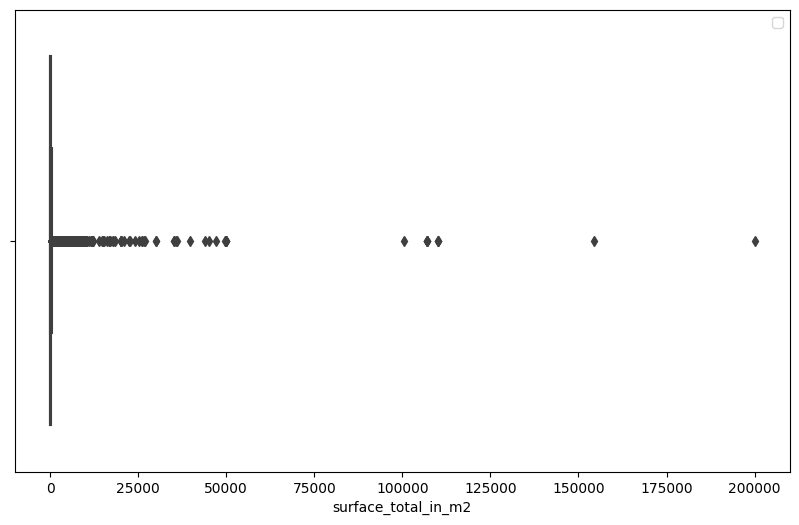

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['surface_total_in_m2'])

plt.plot([], [], 'ro', markersize=5)
plt.legend()

plt.show()

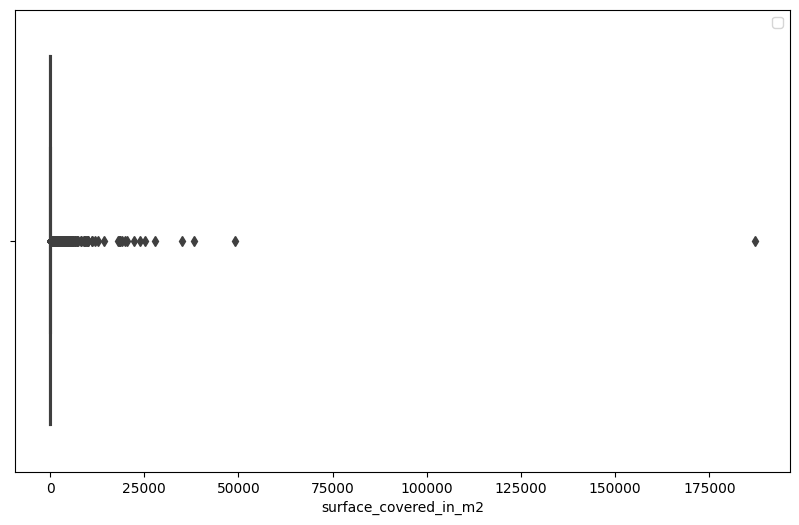

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['surface_covered_in_m2'])

plt.plot([], [], 'ro', markersize=5)
plt.legend()


plt.show()

> A partir de los datos recabados , vemos que hay 34497 nulos en alguna columna de las columnas de superficie total o cubierta y 12369 en datos nulos en ambas columnas de superficie. Realizaremos una búsqueda mediante expresiones regulares de esa información en la columna de descripción. Para hacer más sencillo el análisis, armare dos pequeños datasets: uno que contenga la columna de descripción y superficie total (data_sup_total_descripcion), y otro que tenga la columna de descripción y superficie cubierta(data_sup_cubierta_descrpcion). Veo si la forma de ambos datsets coincide con la información de nulos recabada,

In [ ]:
mask_nulos_superficie_total=data["surface_total_in_m2"].isnull()
mask_nulos_superficie_cubierta=data["surface_covered_in_m2"].isnull()

data_sup_total_descripcion=data.loc[mask_nulos_superficie_total, ["surface_total_in_m2", "description"]]
data_sup_cubierta_descripcion=data.loc[mask_nulos_superficie_cubierta, ["surface_covered_in_m2", "description"]]
print("shape de data_sup_total_descrpcion: ", data_sup_total_descripcion.shape)
print("shape de data_sup_cubierta_descrpcion ", data_sup_cubierta_descripcion.shape)
print("Filas con nulos en columna superficie total: ", nulos_total)
print("Filas con nulos en columna superficie cubierta: ", nulos_covered)
#se observa que coinciden la cantidad de nulos coindice

shape de data_sup_total_descrpcion:  (39091, 2)
shape de data_sup_cubierta_descrpcion  (19812, 2)
Filas con nulos en columna superficie total:  39091
Filas con nulos en columna superficie cubierta:  19812


> Se observa que coincide la cantidad de filas de cada data set con la cantidad de nulo de cada superficie. Con eso chequeado, se pasan los tipos de datos de las columnas de cada data set a tipo string y se generan tres expresiones regulares para los dos data sets: uno que sólo busca algún número y el sufijo de m2, otra que además de esa expresión agrega el sufijo "cub" (por cubierta) y otra que agrega el sufijo "tot" (por totales). Las expresiones que buscan m2 y m2 totales lo harán en el data_sup_total_descripcion y la otra lo hará en el data_sup_cubierta_decsrpcion

In [ ]:
#paso los datos de decsripción a tipo de dato string
descripcion=data.loc[mask_nulos_superficie_total].description.astype(str)
descripcion_2=data_sup_cubierta_descripcion.description.astype(str)

#genero expresiones regulares
pattern_metraje= '(?P<numero_metraje>\d+)\s*(?P<sufijo_m2>m2)'
pattern_metraje_regex=re.compile(pattern_metraje, flags=re.IGNORECASE)
resultado_1=descripcion.apply(lambda x: pattern_metraje_regex.search(x))
resultado_no_nulo=resultado_1.notnull().sum()
print("se encontaron ",resultado_no_nulo, "resultados no nulos")

pattern_metraje_cubierto= '(?P<numero_metraje>\d+)\s*(?P<sufijo_m2>m2)\s*(?P<sufijo_cubierto>cub)'
pattern_metraje_cubierto_regex=re.compile(pattern_metraje_cubierto, flags=re.IGNORECASE)
resultado_2=descripcion_2.apply(lambda x: pattern_metraje_cubierto_regex.search(x))
resultado_no_nulo_2=resultado_2.notnull().sum()
print("se encontaron ",resultado_no_nulo_2, "resultados no nulos para metros cubiertos")

pattern_metraje_totales= '(?P<numero_metraje>\d+)\s*(?P<sufijo_m2>m2)\s*(?P<sufijo_totales>tot)'
pattern_metraje_totales_regex=re.compile(pattern_metraje_totales, flags=re.IGNORECASE)
resultado_3=descripcion.apply(lambda x: pattern_metraje_totales_regex.search(x))
resultado_no_nulo_3=resultado_3.notnull().sum()
print("se encontaron ",resultado_no_nulo_3, "resultados no nulos para metros totales")

se encontaron  7726 resultados no nulos
se encontaron  396 resultados no nulos para metros cubiertos
se encontaron  442 resultados no nulos para metros totales


> A partir de los resultados de la búsqueda de las 3 expresiones regulares en las columnas de descripción de ambos data set reducidos se observa que se pueden recuperar 7783 resultados de metraje cuadrado, de los cuales 402 son cubiertos y 444 totales. Para poder verlos más claramente, armaremos dos columnas en data_sup_total_descrpcion con lo que se encuentró en la expresión de metros cuadrados y metros cuadrados totales y en el data set data_sup_cubierto_decripcion agregaré una columna con lo que se repone de metros cuadrados cubiertos. Los datos de las columnas agregadas repondran solamente el número en formato tipo float.

In [ ]:
mask_resul_1=resultado_1.notnull()
m2=resultado_1[mask_resul_1].apply(lambda x: x if x is None else x.group('numero_metraje'))
data_sup_total_descripcion['m2_descripcion']=m2.astype(float)
mask_not_null_m2=data_sup_total_descripcion.m2_descripcion.notnull()
data_sup_descripcion_no_nulo=data_sup_total_descripcion[mask_not_null_m2]

mask_resul_3=resultado_3.notnull()
m2_total=resultado_1[mask_resul_3].apply(lambda x: x if x is None else x.group('numero_metraje'))
data_sup_total_descripcion['m2_descripcion_total']=m2_total.astype(float)
mask_not_null_m2_total=data_sup_total_descripcion.m2_descripcion_total.notnull()
data_sup_descripcion_total_no_nulo=data_sup_total_descripcion[mask_not_null_m2_total]
data_sup_descripcion_total_no_nulo.head(5)

,surface_total_in_m2,description,m2_descripcion,m2_descripcion_total
137,NaN,Corredor Responsable: Jose Guendler - C.U.C.I....,63.0,63.0
869,NaN,Corredor Responsable: Raul Hector Merlo - CUCI...,84.0,84.0
1534,NaN,Corredor Responsable: Raul Hector Merlo - CUCI...,84.0,84.0
1535,NaN,Corredor Responsable: SABRINA COCCONI - CSI 62...,327.0,327.0
4951,NaN,CODIGO: 1697-hprimo338 ubicado en: Humberto Pr...,88.0,88.0


> Para que la visualización y extracción de datos se más clara unire los data sets data_sup_cubierta_descripcion y data_sup_total_descripcion en un solos data set con la columna de descripción unificada las dos columnas de superficie originales del data set y las tres columnas nuevas de descripción.

In [ ]:
mask_resul_2=resultado_2.notnull()
m2_cubierta=resultado_2[mask_resul_2].apply(lambda x: x if x is None else x.group('numero_metraje'))
data_sup_cubierta_descripcion['m2_descripcion_cubierta']=m2_cubierta.astype(float)
mask_not_null_m2_cubierta=data_sup_cubierta_descripcion.m2_descripcion_cubierta.notnull()
data_sup_cubierta_descripcion_no_nulo=data_sup_cubierta_descripcion[mask_not_null_m2_cubierta]
data_sup_cubierta_descripcion_no_nulo.head(5)

,surface_covered_in_m2,description,m2_descripcion_cubierta
175,NaN,Corredor Responsable: Silvina Gallegos - Matri...,55.0
675,NaN,VIVINEDA CON LOCAL / CHALET 3 AMB consta de ...,190.0
873,NaN,Corredor Responsable: Caroline Hogner - CCI St...,164.0
1017,NaN,CODIGO: 3714-114 ubicado en: parera 4500 - Pu...,77.0
1060,NaN,Emplazado en inmejorable ubicación a una cuadr...,44.0


In [ ]:
data_superficie_nulas=data_sup_descripcion_total_no_nulo.merge(data_sup_cubierta_descripcion_no_nulo,on=['description'],how='outer')
data_superficie_nulas
columnas=list(data_superficie_nulas)
columnas[:]=columnas[1],columnas[0],columnas[4],columnas[2],columnas[3],columnas[5]
columnas
data_superficie_nulas=data_superficie_nulas[columnas]
data_superficie_nulas.sample(7)

,description,surface_total_in_m2,surface_covered_in_m2,m2_descripcion,m2_descripcion_total,m2_descripcion_cubierta
462,CODIGO: 2089-VM48 ubicado en: Av Santa Fe y La...,NaN,NaN,NaN,NaN,100.0
387,Departamento en venta de 1 dormitorio45 m2 tot...,NaN,NaN,45.0,45.0,NaN
725,Haras del Pilar barrio El Establo. Excelente c...,NaN,NaN,NaN,NaN,180.0
697,"Casa de 5000m2, 500m2 cubiertos, ubicada en el...",NaN,NaN,NaN,NaN,500.0
504,Venta de Departamento 3 AMBIENTES en Las Cañit...,NaN,NaN,NaN,NaN,81.0
51,Corredor Responsable: Ramiro Cappelloni - C.M....,NaN,NaN,1500.0,1500.0,NaN
86,AMPLIO LOCAL COMERCIAL SOBRE IMPORTANTE AVENID...,NaN,NaN,550.0,550.0,NaN


> Una vez unificada analizaremos las coulmnas mediante un .describe() para ver si los datos recuperados por expresiones regulares son confiables y se pueden imputar a las columnas originales de superficie. Tomamos las dos columnas de superficie como muestra

In [ ]:
data_superficie_nulas['m2_descripcion_cubierta'].describe()

count       396.000000
mean       1233.060606
std       21107.529388
min           0.000000
25%          61.500000
50%         110.000000
75%         220.000000
max      420180.000000
Name: m2_descripcion_cubierta, dtype: float64

In [ ]:
data['surface_covered_in_m2'].describe()

count    100551.000000
mean        127.415073
std         700.919118
min           0.000000
25%          45.000000
50%          74.000000
75%         150.000000
max      187000.000000
Name: surface_covered_in_m2, dtype: float64

> Al ver lo que dan los valores del .describe() de la columna m2_descripcion_cubierta, podemos observar que el máximo que tira es un número muy grande comparado con la columna del data set original por lo que imputar los datos recuperados de la columna descripción puede resultar en outliers y en problemas para el posterior análisis de datos.

> Como segunda estrategia, veremos si hay coincidencias de nulos entre las columnas de precio y datos y las que tengan nulos en ambas columnas serán dropeadas ya que dificultan el análisis.

In [ ]:
mask_nulos_precio_superficie=mask_precio_is_null&mask_nulos_superficie_total&mask_nulos_superficie_cubierta

data_mask_nan=data.loc[mask_nulos_precio_superficie,['price','currency','price_aprox_ARS','price_aprox_usd','surface_total_in_m2','surface_total_in_m2']]

data=data.drop(data[mask_nulos_precio_superficie].index)
#print(data.shape)
#print(data.shape)

> Analizamos el porcentaje de nulos del dataset sin los valores nulos de las columnas de precio y superficie

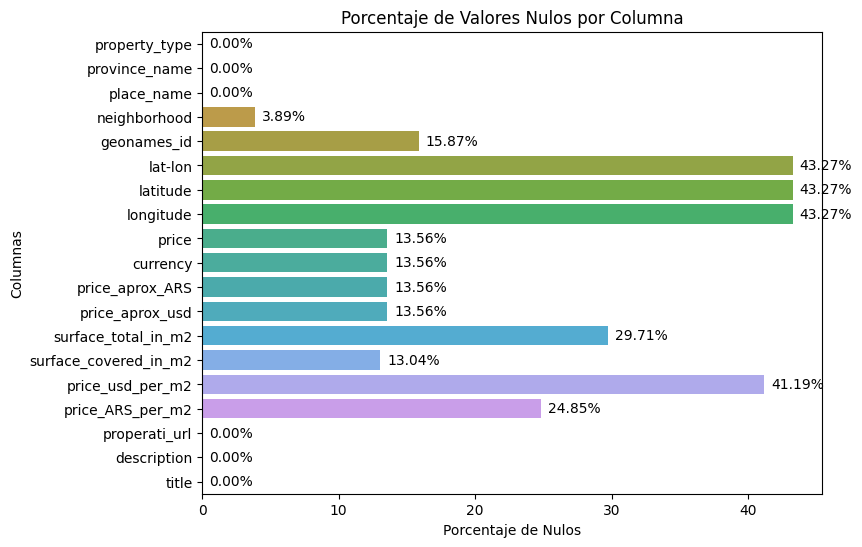

In [ ]:
graficar_nulos(data)

> Luego, vamos a ver si podemos dropear outliers de supeficie cubierta y superficie toal. Para ello, primero arameros dos boxplot con los datos no nulos de superficie total y superficie cubierta, separados por tipo de propiedad

In [ ]:
mask_superficie_not_null=data.surface_covered_in_m2.notnull() & data.surface_total_in_m2.notnull()
data_superficie=data.loc[mask_superficie_not_null,['property_type','surface_covered_in_m2','surface_total_in_m2']]
data_superficie.head(5)

,property_type,surface_covered_in_m2,surface_total_in_m2
0,PH,40.0,55.0
2,apartment,55.0,55.0
4,apartment,35.0,35.0
6,PH,78.0,106.0
7,apartment,40.0,45.0


<Axes: xlabel='property_type', ylabel='surface_total_in_m2'>

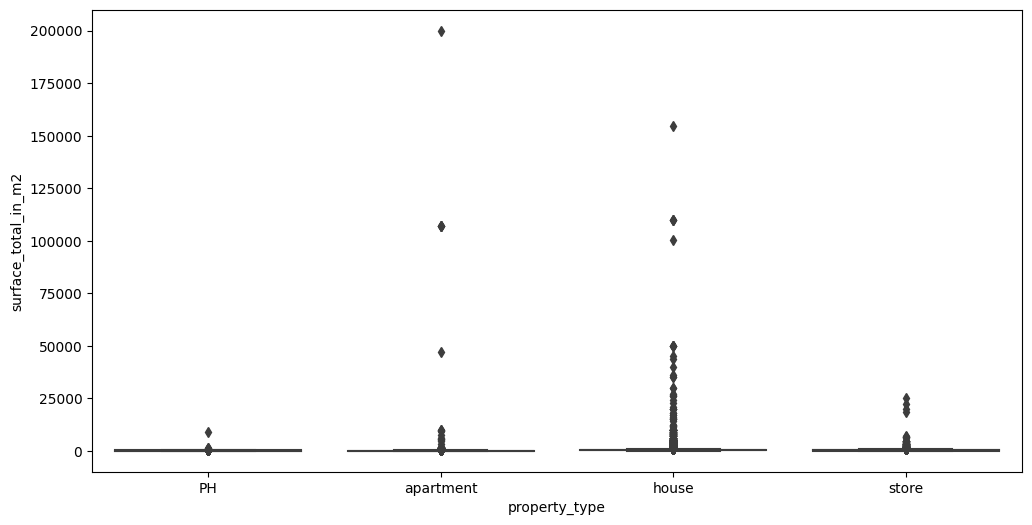

In [ ]:
fig, axs = plt.subplots(ncols=1, figsize=(12,6))

sns.boxplot(y ="surface_total_in_m2", x="property_type", data=data_superficie)

<Axes: xlabel='surface_total_in_m2', ylabel='Count'>

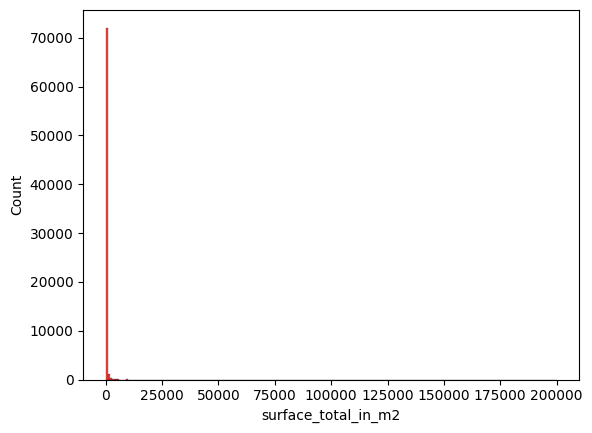

In [ ]:
sns.histplot(data_superficie['surface_total_in_m2'], color = "red", bins = 200)

<Axes: xlabel='property_type', ylabel='surface_covered_in_m2'>

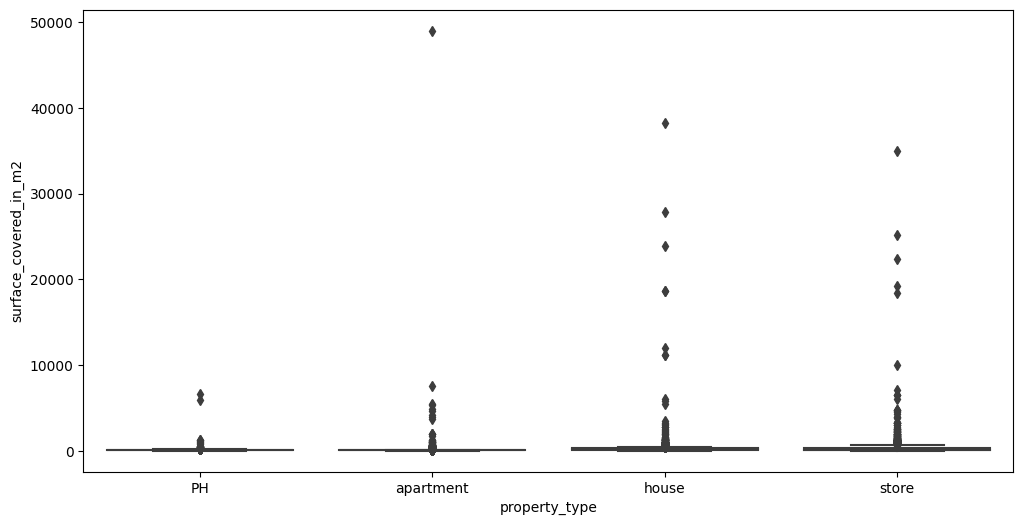

In [ ]:
fig, axs = plt.subplots(ncols=1, figsize=(12,6))

sns.boxplot(y = "surface_covered_in_m2", x='property_type', data=data_superficie)

<Axes: xlabel='surface_covered_in_m2', ylabel='Count'>

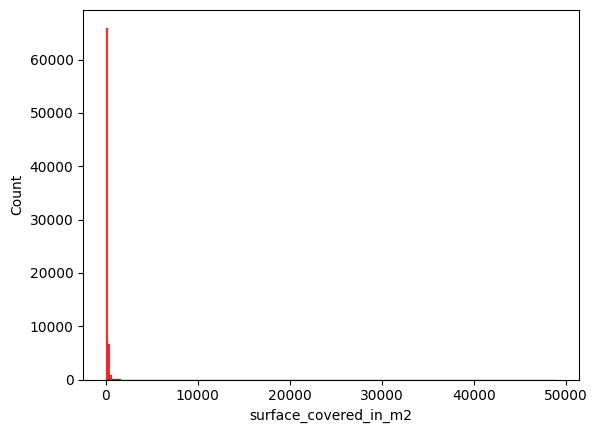

In [ ]:
sns.histplot(data_superficie['surface_covered_in_m2'], color = "red", bins = 200)

Se observa que los outliers son similares, independientemente del tipo de propiedad. Se procede a analizar la columna en su totalidad y hacer el dropeo de outliers

In [ ]:
data_superficie['surface_total_in_m2'].describe(percentiles=[.25, .5, .75,.99]).round(0)

count     73782.0
mean        228.0
std        1653.0
min          10.0
25%          51.0
50%          85.0
75%         200.0
99%        1600.0
max      200000.0
Name: surface_total_in_m2, dtype: float64

In [ ]:
data_superficie['surface_covered_in_m2'].describe(percentiles=[.25, .5, .75,.99]).round(0)

count    73782.0
mean       123.0
std        393.0
min          0.0
25%         45.0
50%         72.0
75%        147.0
99%        560.0
max      49000.0
Name: surface_covered_in_m2, dtype: float64

Habiendo analizado las dos columnas de superficie con los datos no nulos, procederemos a borrar los regsitros cuyos valores están por encima del percentil .98 ya que los asumismos como errores en el dataset y que no corresponden al modelo.

In [ ]:
mask_surface_total_99=data.surface_total_in_m2 > 1700
mask_surface_covered_99=data.surface_covered_in_m2 > 620
data.drop(data[mask_surface_total_99].index)
data.drop(data[mask_surface_covered_99].index)
data.shape

(115630, 19)

## **4 - d)** Columnas geo_names_id, lat, lon, latitude, longitude


Comparamos las columnas lat-lon, latitude, longitude
* cantidad de NaN + not NaN igual al total de elementos
* comparacion 1 los campos nulos coinciden en lat-lon y latitud
* comparacion 2 los campos nulos coinciden en latitud y logitud




In [ ]:
location_columns = ["lat-lon", "latitude", "longitude"]
nan_total_location = data[location_columns].isna().sum()
not_null_location = data[location_columns].notna().sum()
total_columns = data.shape[0]
print(f"NaN + not NaN: {nan_total_location[0] + not_null_location[0]} == total: {total_columns}")

na_geo_masks = data[location_columns].isna()
comparacion_1 = (na_geo_masks["lat-lon"] == na_geo_masks["latitude"]).all()
comparacion_2 = (na_geo_masks["latitude"] == na_geo_masks["longitude"]).all()
print(f"Comparación 1: {comparacion_1}, Comparación 2: {comparacion_2}")

NaN + not NaN: 115630 == total: 115630
Comparación 1: True, Comparación 2: True



> Con esto vemos que los campos latitud y longitud coinciden con lat-lon, por lo que podremos usar cualquiera de los dos



> Ahora convierto la columna lat-lon en tipo **geometry**

In [ ]:
data['lat-lon'] = gpd.points_from_xy(data.longitude, data.latitude)

Luego graficamos los puntos en un mapa para ver si hay algun dato fuera del país

<ipython-input-520-22f791f982e2>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


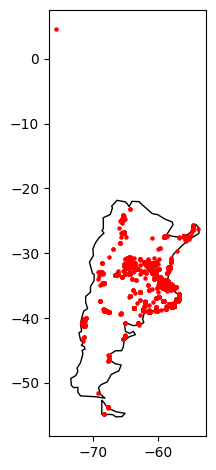

In [ ]:
def graficar_pais(data):
    geo_df = gpd.GeoDataFrame(data, geometry=data['lat-lon'])
    # cargamos el geodataframe world de pandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    # filtramos el mapa de Argentina y ploteamos los puntos
    argentina = world[world['name'] == 'Argentina']

    fig, ax = plt.subplots()

    argentina.plot(ax=ax, color='white', edgecolor='black')
    geo_df.plot(ax=ax, color='red', markersize=5)

    plt.tight_layout()
    plt.show()

graficar_pais(data)

Vemos que hay un outlier:
* creamos una mascara booleana
* identificamos el outlier y lo seteamos NaN
* volvemos a graficar

<ipython-input-520-22f791f982e2>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


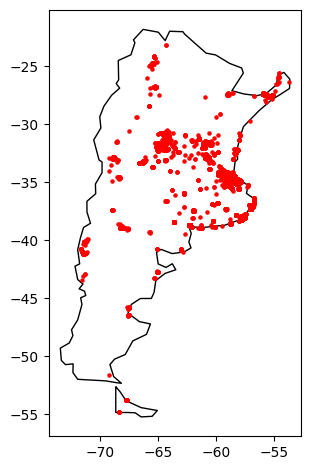

In [ ]:
# mascara latitud > 0 (arriba del ecuador)
# print(data[data['latitude'] >= 0])

# seteamos ese valor a NaN
data.loc[data['latitude'] >= 0, ["lat-lon", "latitude", "longitude"]] = np.nan

# volvemos a graficar
graficar_pais(data)

## **4 - e)** Columna properati_url

> En el campo properati_url hay información que nos podría ser util en un futuro.
Empezamos buscando con una regex con un patron que nos permita encontrar cualquier palabra seguida de "_" y que puede contener un "-".

In [ ]:
url_regex = r"_([a-z\-]+)"
url_df_columns = data["properati_url"].apply(lambda row: re.findall(url_regex, row)).apply(pd.Series)
url_df_columns.sample(3)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
29898,venta,ph,cordoba,jacinto-rios-,piscina,garage,amenities,inmobiliaria-cuatroraices,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55817,venta,casa,cordoba,pw-inmobiliaria,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120722,venta,casa,paternal,justo-juan-b-av-,caian-negocis-inmobiliarios,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Podemos ver lo siguiente por columna:

1.   Columna 0 y 1: datos de **operación** y **tipo de propiedad**
2.   Columnas intermedias: datos de **amenities** y **subte**
3.   Ultima columna: nombre de la **inmobiliaria**

In [ ]:
property_types = url_df_columns[0].unique()
propiedades = {}
for property_type in property_types:
    mask = url_df_columns[0] == property_type
    propiedades[property_type] = data[mask]
    print(f"en {property_type}: {propiedades[property_type].shape[0]}")

en venta: 115504
en alquiler: 124
en alquiler-temporal: 2


> Esta data es más completa que la columna que eliminamos operation(era todo venta), pero tampoco agrega demasiada información ya que es un porcentaje muy bajo

In [ ]:
# comparo el tipo de propiedad obtenido y el que ya tenía
print(url_df_columns[1].value_counts())
print(data.property_type.value_counts())

departamento           68373
casa                   37771
ph                      5553
local                   3786
campo                     38
departamentos             34
terreno                   23
otro                      19
oficina-consultorio       13
cochera                   10
edificio                   4
quinta                     3
galpon                     2
loft                       1
Name: 1, dtype: int64
apartment    68417
house        37835
PH            5580
store         3798
Name: property_type, dtype: int64


> La columna con los datos de tipo de propiedad también tiene más información pero pero muy similar en promedio, por lo cual no modificamos la columna tampoco

> Podemos obtener también información acerca de los amenities que tienen las propiedades

In [ ]:
amenities = [
    "balcon", "piscina", "baulera", "jardin", "toilette", "terraza", "suite", "garage", "gimnasio",
    "lavadero", "placard", "patio","parrilla","aire-acondicionado", "sum", "sauna", "hidromasaje",
    "vestidor", "losa-radiante", "amoblado"
]

# (balcon|piscina|baul...)
regex_pattern = "(" + "|".join(amenities) + ")"
data["amenities"] = data["properati_url"].str.findall(regex_pattern, flags=re.IGNORECASE).apply(lambda x: np.nan if len(x) == 0 else x)
data[["properati_url", "amenities"]].sample(5)

,properati_url,amenities
48547,http://www.properati.com.ar/19abf_venta_ph_cap...,[patio]
107340,http://www.properati.com.ar/1bxx1_venta_depart...,NaN
79252,http://www.properati.com.ar/1avb7_venta_depart...,NaN
55884,http://www.properati.com.ar/19pt8_venta_depart...,"[balcon, placard]"
104578,http://www.properati.com.ar/1btgz_venta_depart...,"[balcon, garage]"


Ahora queremos sacar la información de que **inmobiliaria** esta publicando veo que siempre el ultimo caracter de la cadena exceptuando algunas veces que hay caracteres de 3 o 4 digitos como em7

In [ ]:
def obtener_inmobiliaria(row):
    result = row.split("_")
    inmobiliaria = (result[-1] if len(result[-1]) > 3 else result[-2]).replace("-", " ")
    return inmobiliaria

data["inmobiliaria"] = data["properati_url"].apply(obtener_inmobiliaria)
data["inmobiliaria"].value_counts()

sergio villella bienes raices                   2342
colegio inmobiliario de cordoba                 1322
mieres propiedades                              1182
interwin                                         929
garcia andreu                                    919
                                                ... 
reyna novillo estudio juridico inmobiliairio       1
mare cia inmobiliaria                              1
la roca servicios inmobilirios                     1
arc bienes raices                                  1
c favia operaciones inmobiliarias                  1
Name: inmobiliaria, Length: 3580, dtype: int64

> Podemos obtener las **lineas de subte** también

In [ ]:
# Definir patrón de expresión regular para buscar información de línea de subte
regex_pattern = r"subte[a-z\-]+"

data["subte"] = data["properati_url"].str.findall(regex_pattern, flags=re.IGNORECASE)
data["subte"] = data["subte"].apply(lambda x: x if len(x) > 0 else np.nan)
# data[data["subte"].notna()]["subte"]

> Ahora veamos que **porcentaje de nulos** tienen las **columnas nuevas** obtenidas

In [ ]:
null_percentage = data[["subte", "inmobiliaria", "amenities"]].isnull().mean() * 100
print(null_percentage)

subte           87.540431
inmobiliaria     0.000000
amenities       14.445213
dtype: float64


> Si bien **subte** pareceria no aportar mucha información debido a la gran cantidad de datos nulos, vamos a ver la cantidad de nulos pero filtrando por province_name = Capital Federal

In [ ]:
data.loc[data["province_name"]=="Capital Federal",["subte"]].isnull().mean() * 100


subte    54.746019
dtype: float64

> Sigue siendo un porcentaje muy alto de nulos pero es un dato que nos puede llegar a servir, por lo que lo dejaremos en el dataset

---
# **Gráficos y análisis**

##**5 - a)** Porcentaje de nulos después de las transformaciones y limpiezas

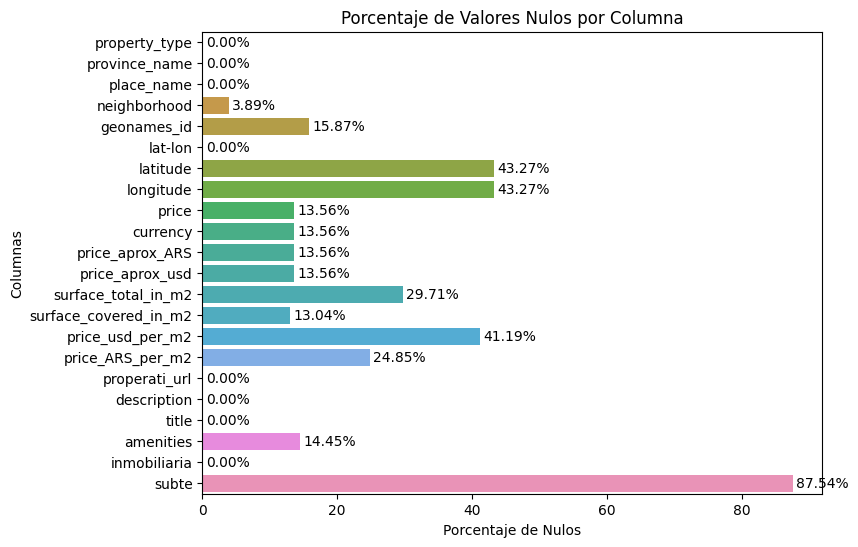

In [ ]:
graficar_nulos(data)

## **5 - b)** Precio del metro cuadrado por provincia y cantidad de propiedades

In [ ]:
data_precios_promedio_provincia_m2 = data.groupby('province_name').filter(lambda x: len(x) >= 100).groupby('province_name')[['price_usd_per_m2', 'latitude', 'longitude']].agg('mean')
data_precios_promedio_provincia_m2

,price_usd_per_m2,latitude,longitude
province_name,,,
Bs.As. G.B.A. Zona Norte,1801.845158,-34.460965,-58.656649
Bs.As. G.B.A. Zona Oeste,1329.322003,-34.644578,-58.639178
Bs.As. G.B.A. Zona Sur,1522.796971,-34.795724,-58.305247
Buenos Aires Costa Atlántica,1575.031865,-37.822752,-57.458484
Buenos Aires Interior,953.503728,-36.901057,-60.465286
Capital Federal,3053.595766,-34.601851,-58.436406
Chubut,1596.403367,-43.818182,-66.510884
Corrientes,1492.307008,-27.827446,-57.748147
Córdoba,1207.081671,-31.463745,-64.271498


> Cuantas propiedades por provincia cumplen con los requisitos que pusimos? (no son nulos para las columas evaluadas y son son más de 100 por provincia?)


In [ ]:
recuento_por_provincia = data.groupby('province_name').filter(lambda x: len(x) >= 100).groupby('province_name')[['price_usd_per_m2', 'latitude', 'longitude']].size()
recuento_por_provincia

province_name
Bs.As. G.B.A. Zona Norte        25087
Bs.As. G.B.A. Zona Oeste         9092
Bs.As. G.B.A. Zona Sur          13194
Buenos Aires Costa Atlántica     9763
Buenos Aires Interior            2190
Capital Federal                 31774
Chubut                            231
Corrientes                        561
Córdoba                         11324
Entre Ríos                        328
La Pampa                          103
Mendoza                           533
Misiones                          451
Neuquén                           576
Río Negro                         620
Salta                             122
San Luis                          232
Santa Fe                         8655
Tucumán                           581
dtype: int64

<ipython-input-533-88943076eaf8>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


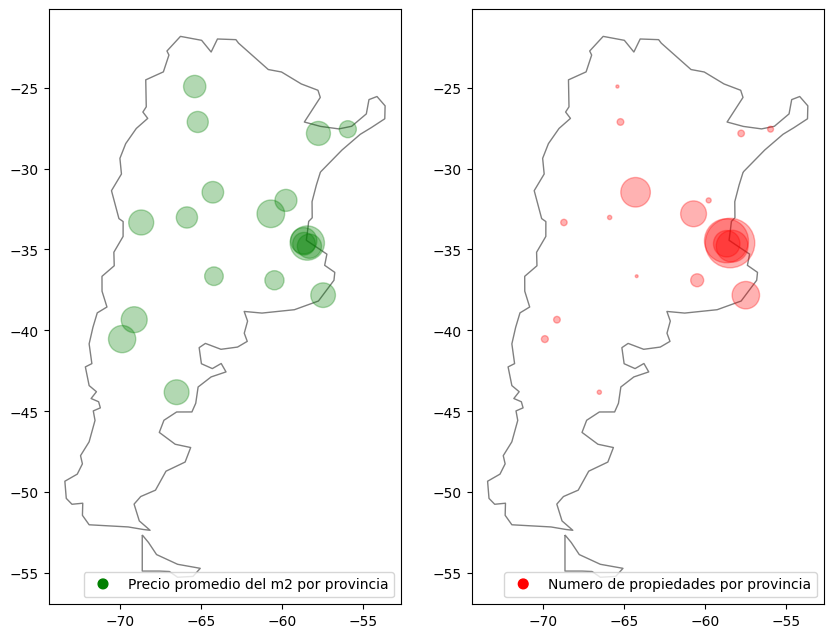

In [ ]:
# Y graficamos en un mapa de ARG
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

argentina = world[world['name'] == 'Argentina']

# Agregar límites del país (Argentina) al gráfico
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))
arg = argentina.plot(ax= ax1, figsize=(10, 10), color='white', edgecolor='grey')
arg = argentina.plot(ax= ax2, figsize=(10, 10), color='white', edgecolor='grey')

# Traemos la ubicación de las las provincias (como esto es compartido, lo traemos una vez)
localidades = gpd.GeoDataFrame(geometry=gpd.points_from_xy(data_precios_promedio_provincia_m2.longitude, data_precios_promedio_provincia_m2.latitude))

# Traemos el precio del metro cuadrado y los escalamos
precios = data_precios_promedio_provincia_m2.price_usd_per_m2
sizes1 = [i /5 for i in precios]

# Dibujar los puntos de precios con tamaños escalados
localidades.plot(ax=ax1, markersize=sizes1, alpha=0.3, color='green')

# y ponemos la leyebda

class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        x = width / 2
        y = height / 2
        radius = min(width, height) / 2
        p = plt.Circle((x, y), radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

legend_elements = [Patch(facecolor='green', edgecolor='green', label='Precio promedio del m2 por provincia')]
ax1.legend(handles=legend_elements, loc='lower right', handler_map={Patch: HandlerCircle()})


# Ahora traemos el recuento de puntos por provincia
# Escalar los tamaños
sizes2 = [i /25 for i in recuento_por_provincia]

# Dibujar los puntos con tamaños escalados
localidades.plot(ax=ax2, markersize=sizes2, alpha=0.3, color='red')

legend_elements = [Patch(facecolor='red', edgecolor='red', label='Numero de propiedades por provincia')]
ax2.legend(handles=legend_elements, loc='lower right', handler_map={Patch: HandlerCircle()})

# Mostrar el gráfico
plt.show()

## **5 - c)** Distribución de precios por provincia

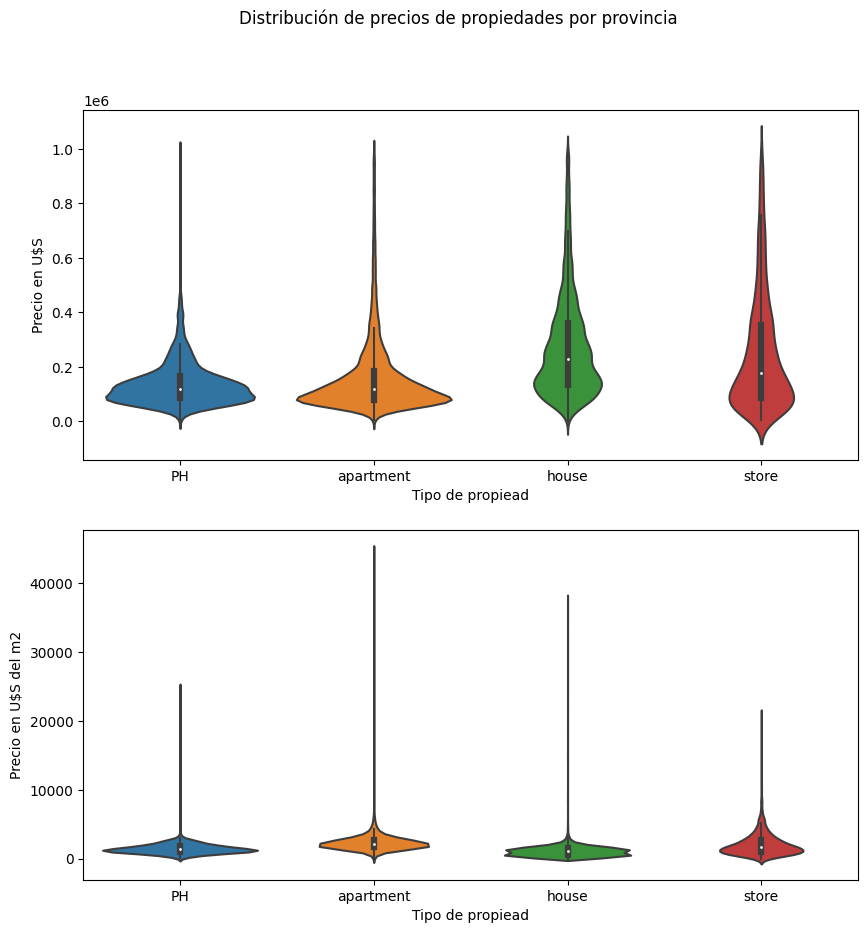

In [ ]:
# Violines por provincia
# Para poder apreciar la distribución de los datos, necesitamos quitarnos de ensima los valores extremos. Filtramos las propieades que valen menos de 1M U$S
data_violines = data[data['price_aprox_usd'] < 1000000]

# Crear el violin plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 10)) # Tamaño de la figura

# Utilizar seaborn para crear el violin plot
sns.violinplot(ax= ax1, x='property_type', y='price_aprox_usd',  data = data_violines , split=False)

sns.violinplot(ax= ax2, x='property_type', y='price_usd_per_m2',  data = data_violines , split=False)


# Añadir título y etiquetas a los ejes
fig.suptitle('Distribución de precios de propiedades por provincia')

ax1.set_ylabel('Precio en U$S')
ax2.set_ylabel('Precio en U$S del m2')
ax1.set_xlabel('Tipo de propiead')
ax2.set_xlabel('Tipo de propiead')

# Mostrar el plot
plt.show()

5 - d) Composición del tipo de propiedad en el mercado inmobiliario

In [ ]:
# composición del tipo de propieadad en el mercado inmobiliario

# Nos quedamos solo con las lineas que podamos analizar. Dropeamos los que no tegnan tipo de propiead

data_pivot_table = data.dropna(subset = ['property_type'])

# Creamos una tabla dinámica de tipo de propiead en cada provincia, utilizando como funcion de agregación el reecuento de casos.

tabla_pivot = pd.pivot_table(data_pivot_table[['property_type', 'province_name']], index='province_name', columns='property_type', aggfunc=len)

# como nos parece interesante analizar el porcentaje de cada tipo de propiedad, creamos una serie que recuenta las casas por distrito
serie = tabla_pivot.sum(axis = 1)

# Y dividimos nuestro dataset por la serie anterior usando la funcionalidad de broadcasting que presenta Pandas:

tabla_pivot = tabla_pivot / serie[:, np.newaxis]
tabla_pivot = tabla_pivot.sort_values(by='apartment', ascending = False)
tabla_pivot

<ipython-input-535-d1162a08b789>:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tabla_pivot = tabla_pivot / serie[:, np.newaxis]


property_type,PH,apartment,house,store
province_name,,,,
Capital Federal,0.057217,0.839743,0.062472,0.040568
Santa Fe,0.005777,0.827845,0.148007,0.018371
Formosa,NaN,0.815385,0.184615,NaN
Buenos Aires Costa Atlántica,0.057769,0.649698,0.264878,0.027655
Tucumán,0.005164,0.647160,0.299484,0.048193
Neuquén,0.157986,0.565972,0.260417,0.015625
Córdoba,0.034175,0.550336,0.378576,0.036913
San Juan,NaN,0.545455,0.363636,0.090909
Mendoza,0.005629,0.530957,0.418386,0.045028


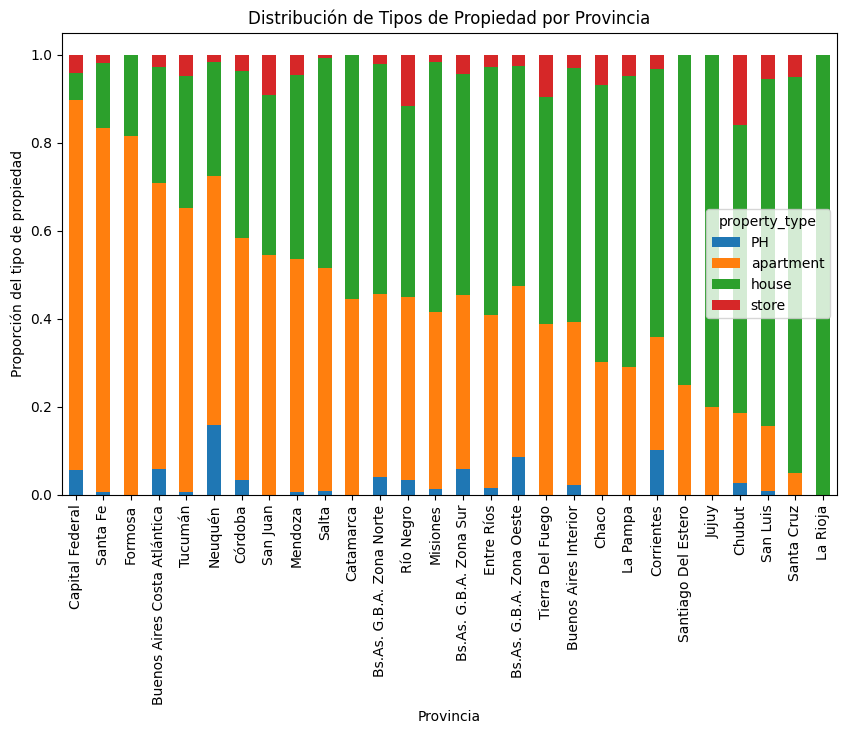

In [ ]:
# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))
tabla_pivot.plot(kind='bar', stacked=True, ax=ax)

# Configurar los títulos y etiquetas
ax.set_title('Distribución de Tipos de Propiedad por Provincia')
ax.set_xlabel('Provincia')
ax.set_ylabel('Proporción del tipo de propiedad')
# ax.legend('tipo de prop', loc='lower right')


# Mostrar el gráfico
plt.show()

## **5 - d)** Distribución del tamaño de propiedades en diferentes regiones del país

In [ ]:
# Como son el tamaño de las propieades en las diferentes regiones del pais?

regiones = {'Noreste' : ['Jujuy', 'Salta', 'Tucumán','Catamarca','La Rioja', 'Santiago del Estero'],
            'Noroeste': ['Formosa', 'Chaco', 'Corrientes', 'Misiones'],
            'Cuyo': ['Mendoza', 'San Juan', 'San Luis' ],
            'Metropolitana' : ['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur', 'Bs.As. G.B.A. Zona Oeste'],
            'Pampeana': ['Buenos Aires Interior', 'Córdoba', 'Entre Ríos', 'La Pampa', 'Santa Fe', 'Buenos Aires Costa Atlántica'],
            'Patagónica' : ['Neuquén', 'Río Negro', 'Chubut', 'Santa Cruz', 'Tierra del Fuego']
            }


# Mapear las provincias a las regiones
data['region'] = data['province_name'].map({provincia: region for region, provincias in regiones.items() for provincia in provincias})

(array([  487.,  6662., 11646., 11055.,  7577.,  4957.,  4043.,  2999.,
         2508.,  2089.,  1834.,  1352.,  1737.,  1174.,  1655.,  1292.,
         1195.,   896.,  1312.,   664.,   685.,  1405.,   414.,   463.,
          656.,   563.,   378.,   479.,   226.,   603.,   275.,   271.,
          168.,   490.,   124.,   191.,   137.,   438.,   151.,    91.,
          182.,   124.,    74.,    97.,   366.,    91.,   111.,    76.,
          138.,    83.]),
 array([ 10.  ,  23.24,  36.48,  49.72,  62.96,  76.2 ,  89.44, 102.68,
        115.92, 129.16, 142.4 , 155.64, 168.88, 182.12, 195.36, 208.6 ,
        221.84, 235.08, 248.32, 261.56, 274.8 , 288.04, 301.28, 314.52,
        327.76, 341.  , 354.24, 367.48, 380.72, 393.96, 407.2 , 420.44,
        433.68, 446.92, 460.16, 473.4 , 486.64, 499.88, 513.12, 526.36,
        539.6 , 552.84, 566.08, 579.32, 592.56, 605.8 , 619.04, 632.28,
        645.52, 658.76, 672.  ]),
 <BarContainer object of 50 artists>)

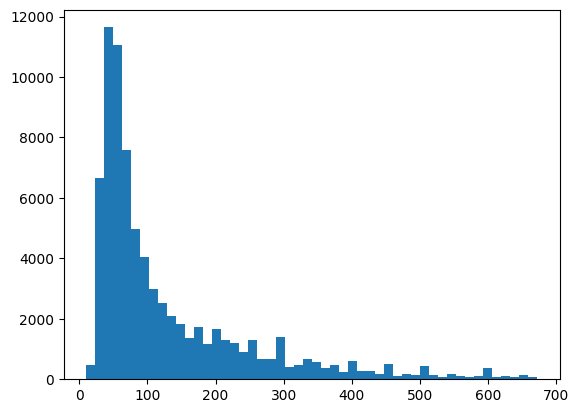

In [ ]:
data_areas_totales = data.dropna(subset=['surface_total_in_m2'])

# Para poder visualizar la distribución de los datos retiramos momentaneamente los datos extremos
data_areas_totales = data_areas_totales[data_areas_totales['surface_total_in_m2'] > 1]
data_areas_totales = data_areas_totales[data_areas_totales['surface_total_in_m2'] < data_areas_totales['surface_total_in_m2'].mean()*3]

plt.hist(data_areas_totales.surface_total_in_m2, bins = 50)

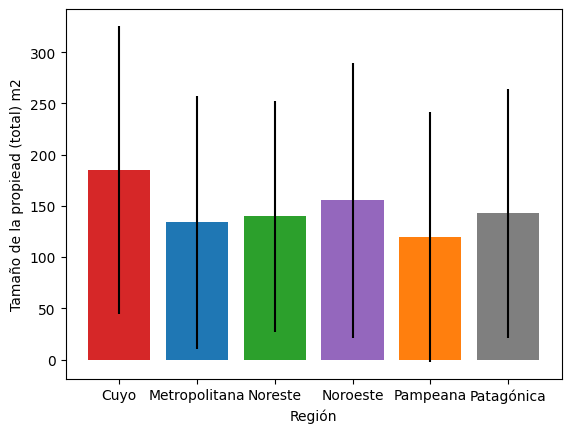

In [ ]:
# Agrupamos por región y graficamos

data_areas_por_region_totales = data_areas_totales.groupby('region')['surface_total_in_m2'].mean()
data_areas_por_region_errores_totales = data_areas_totales.groupby('region')['surface_total_in_m2'].std()

# Datos de ejemplo
x = data_areas_por_region_totales.index # Valores en el eje x

# Crear el gráfico de barras

colores = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange', 'tab:grey']
plt.bar(x, data_areas_por_region_totales, yerr=data_areas_por_region_errores_totales, color = colores)

# Añadir los puntos individuales detrás de cada barra
# for i in range(len(x)):
#     plt.scatter([x[i]] * len(y), np.random.normal(y[i], error[i], len(y)), color='k', alpha=0.5)

# Ajustar los límites y etiquetas de los ejes

plt.xlabel('Región')
plt.ylabel('Tamaño de la propiead (total) m2')

# Mostrar el gráfico
plt.show()

In [ ]:
# No pareciera haber diferencias más alla de una leve tendencia a que en las zonas más pobladas (metropolitana y Pampeana) las propieades son un poco más chicas.

# Podemos evaluar si se oberva lo mismo hacer lo mismo con el área cubierta:

data_areas_cubierto = data.dropna(subset=['surface_covered_in_m2'])
data_areas_cubierto = data_areas_cubierto[data_areas_cubierto['surface_covered_in_m2'] > 1]
data_areas_cubierto = data_areas_cubierto[data_areas_cubierto['surface_covered_in_m2'] < data_areas_cubierto['surface_covered_in_m2'].mean()*3]

data_areas_por_region_cubierto = data_areas_cubierto.groupby('region')['surface_covered_in_m2'].mean()
data_areas_por_region_errores_cubierto = data_areas_cubierto.groupby('region')['surface_covered_in_m2'].std()

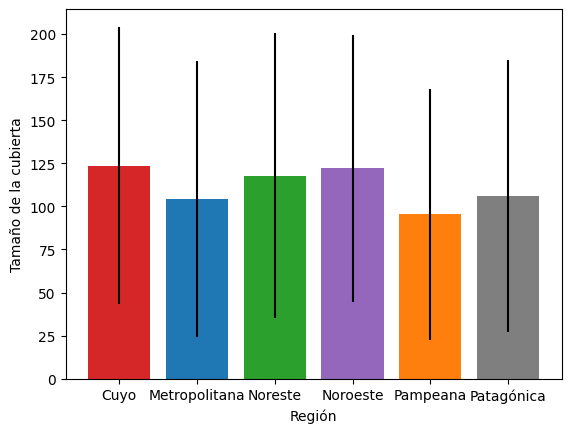

In [ ]:
# Graficamos
x = data_areas_por_region_cubierto.index # Valores en el eje x

colores = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange', 'tab:grey']
plt.bar(x, data_areas_por_region_cubierto, yerr=data_areas_por_region_errores_cubierto, color = colores)

# Añadir los puntos individuales detrás de cada barra

plt.xlabel('Región')
plt.ylabel('Tamaño de la cubierta')

# Mostrar el gráfico
plt.show()

Pues si, no se ven diferencias que sean significativas.


## **5 - e)** Correlación entre price_aprox_usd vs resto de variables

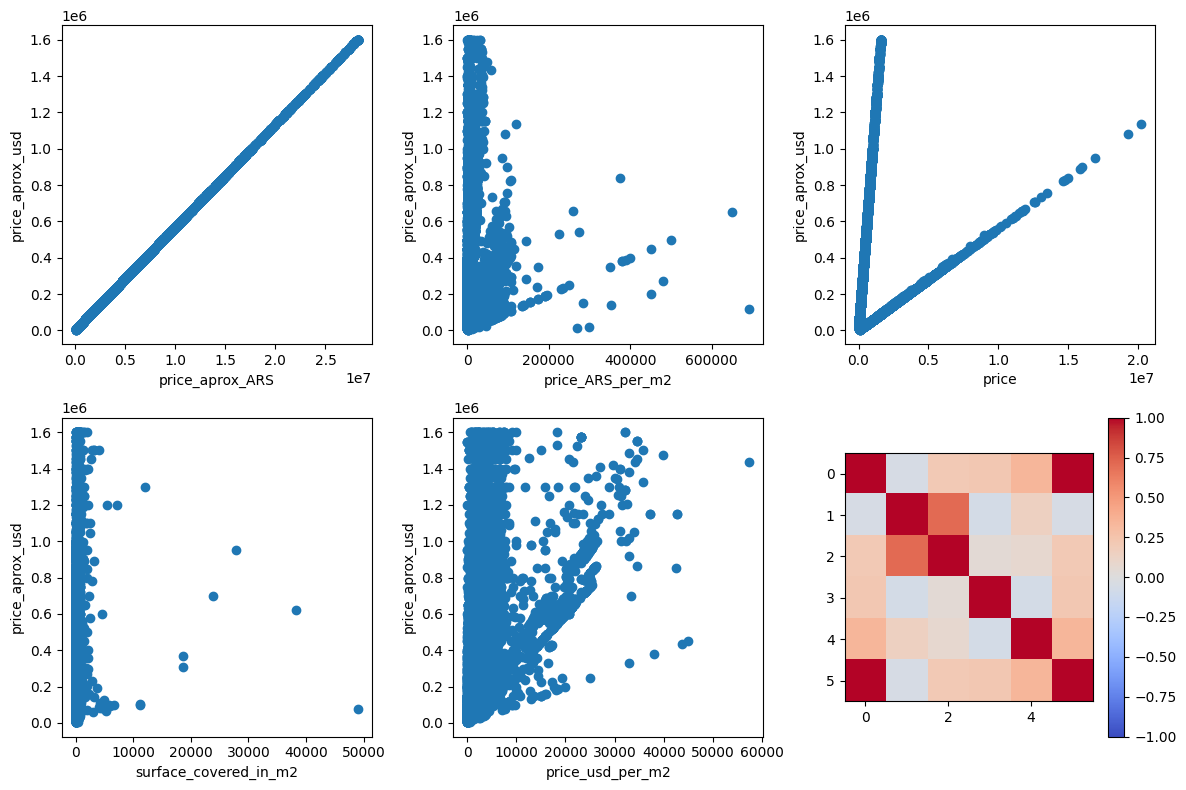

In [ ]:
columns_of_interest = [
    'price_aprox_ARS', 'price_ARS_per_m2', 'price',
    'surface_covered_in_m2', 'price_usd_per_m2', 'price_aprox_usd',
]

filtered_data = data[columns_of_interest].dropna()

correlation_matrix = filtered_data.corr()

correlation_array = np.array(correlation_matrix)

# grafico todo los valores de interes contra price_aprox_usd
# si quiero comparar contra otro cambio el 5 por el indice que quiera
pairs = [(0, 5), (1, 5), (2, 5), (3, 5), (4, 5)]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, pair in enumerate(pairs):
    row = i // 3
    col = i % 3
    axes[row, col].scatter(filtered_data.iloc[:, pair[0]], filtered_data.iloc[:, pair[1]])
    axes[row, col].set_xlabel(columns_of_interest[pair[0]])
    axes[row, col].set_ylabel(columns_of_interest[pair[1]])

ax = axes[1, 2]
im = ax.imshow(correlation_array, cmap='coolwarm', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

# se ve a simple vista que price aprox usd no tiene relacion con nada solo con price aprox ars
# se ve también que se correlaciona un poco también al valor de dolar x m2 casi 0.5 corr

# Conclusiones

En este trabajo de análisis exploratorio del dataset "properatti.csv" de propiedades en Argentina, se realizaron tres pasos principales para comprender la naturaleza de los datos, llevar a cabo modificaciones y limpieza de las columnas, y generar gráficos que nos ayuden a comprender mejor los datos y sus relaciones.

En la **primera etapa**, se presentaron los **datos originales del dataset**, lo que nos permitió entender la estructura y las características generales de las variables. Esto nos proporcionó una visión inicial de la información que teníamos a nuestra disposición.

En la **segunda etapa**, se realizó un **análisis detallado columna por columna**, utilizando técnicas de limpieza de datos con el uso de expresiones regulares y funcionalidades de pandas. Se abordaron los valores nulos y los outliers, encontrando lógicas de reemplazo para reducir su cantidad.

En la **tercera etapa**, se generaron **gráficos** y se llevaron a cabo **análisis adicionales**. Los gráficos proporcionaron una visualización efectiva de la distribución de variables, patrones y relaciones entre los datos. Estas representaciones visuales nos permitieron extraer conclusiones más significativas y comprender mejor los insights presentes en el dataset.

En conclusión, este trabajo de análisis exploratorio del dataset "properatti.csv" nos ha brindado una comprensión más profunda de los datos de propiedades en Argentina. A través de la presentación de los datos originales, la modificación y limpieza de las columnas, y el uso de gráficos para visualizar los patrones y relaciones, hemos obtenido una visión más clara de la naturaleza de los datos y hemos identificado tendencias y características relevantes. Estas conclusiones servirán como base para análisis posteriores y la elaboración de un modelo predictivo en el siguiente trabajo práctico.